In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/ HV-AI-2024.zip" /content/
!unzip /content/' HV-AI-2024.zip'
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/
!rm -rf /content/HV-AI-2024
!rm -rf /content/sample_data
from google.colab import output
output.clear()

# **Plot Sample Images**

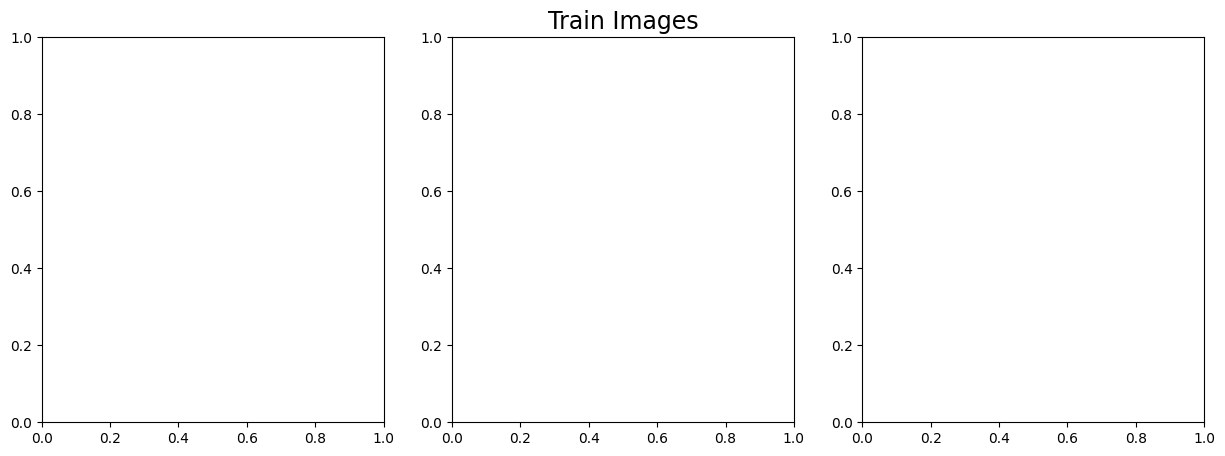

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
import os

train_images = glob('/content/images/train/*.jpg')[0:3]
test_images = glob('/content/images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

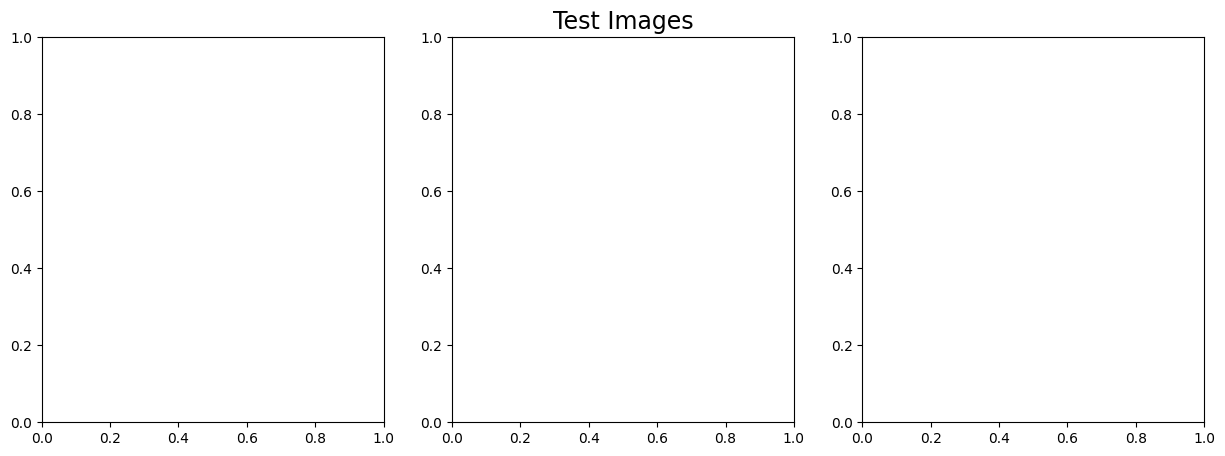

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

# **Load/Preprocess **data****

In [ ]:
import os
import cv2
import pandas as pd
from glob import glob
from shutil import move
import tensorflow as tf

train = pd.read_csv('/content/train.csv')
image_path_to_label = dict(zip(train['path'], train['class']))
image_in_training = glob('/content/images/train/*.jpg')
output_dir = '/content/classified_images/'
os.makedirs(output_dir, exist_ok=True)

for img_train in image_in_training:
    img = cv2.imread(img_train)
    img_name = img_train.replace('/content/', '')
    if img_name in image_path_to_label:
        img_class = image_path_to_label[img_name]
        class_dir = os.path.join(output_dir, str(img_class))
        os.makedirs(class_dir, exist_ok=True)
        img_dest_path = os.path.join(class_dir, os.path.basename(img_train))
        move(img_train, img_dest_path)
print("Images successfully organized by class.")





Images successfully organized by class.


In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 15

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "classified_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5994 files belonging to 200 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2,shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    return train_ds, val_ds,

In [ ]:
train_ds,val_ds = get_dataset_partitions_tf(dataset)

# **Model initialization/Training**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
NUM_CLASSES = 200
def process_labels(image, label):
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label
train_ds = train_ds.map(process_labels)
val_ds = val_ds.map(process_labels)

In [ ]:
model_s = Sequential()
model_s.add(Conv2D(32, (3, 3), activation='elu', input_shape=(256, 256, 3)))
model_s.add(MaxPooling2D(pool_size=(2, 2)))
model_s.add(Conv2D(64, (3, 3), activation='elu'))
model_s.add(MaxPooling2D(pool_size=(2, 2)))
model_s.add(Conv2D(128, (3, 3), activation='elu'))
model_s.add(MaxPooling2D(pool_size=(2, 2)))
model_s.add(Flatten())
model_s.add(Dense(128, activation='elu'))
model_s.add(Dropout(0.5))
model_s.add(Dense(NUM_CLASSES, activation='softmax'))

model_s.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model_s.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
 3/75 ━━━━━━━━━━━━━━━━━━━━ 13:04 11s/step - accuracy: 0.0000e+00 - loss: 2948.0583

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


checkpoint_filepath = 'model_checkpoints/epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[checkpoint_callback])

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.0551 - loss: 5.0321 
Epoch 1: val_accuracy improved from -inf to 0.38802, saving model to model_checkpoints/epoch_01_val_acc_0.39.h5.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1483s 19s/step - accuracy: 0.0558 - loss: 5.0239 - val_accuracy: 0.3880 - val_loss: 2.7655
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4071 - loss: 2.5280 
Epoch 2: val_accuracy improved from 0.38802 to 0.58496, saving model to model_checkpoints/epoch_02_val_acc_0.58.h5.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1442s 19s/step - accuracy: 0.4072 - loss: 2.5269 - val_accuracy: 0.5850 - val_loss: 1.7021
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5706 - loss: 1.6587 
Epoch 3: val_accuracy improved from 0.58496 to 0.73177, saving model to model_checkpoints/epoch_03_val_acc_0.73.h5.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1500s 20s/step - accuracy: 0.5708 - loss: 1.6581 - val_accuracy: 0.7318 - val_loss: 1.1346
Epoch 4/10
75/75 ━━━━━━━━━━━━━━

# **Model Inference**

In [ ]:
BATCH_SIZE=64
IMAGE_SIZE=256

In [ ]:
import shutil
src_dir='/content/images/test'
dst_dir='/content/images/test/category'
if not os.path.exists(dst_dir):
  os.makedirs(dst_dir)
for file_name in os.listdir(src_dir):
  if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        src_path = os.path.join(src_dir, file_name)
        dst_path = os.path.join(dst_dir, file_name)
        shutil.move(src_path, dst_path)


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/images/test',
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5794 files belonging to 1 classes.


In [ ]:
file_paths=test_dataset.file_paths
predictions = model.predict(test_dataset)
predicted_classes =tf.argmax(predictions,axis=1).numpy()
confidence_scores =tf.reduce_max(predictions,axis=1).numpy()
file_paths=test_dataset.file_paths


91/91 ━━━━━━━━━━━━━━━━━━━━ 1383s 15s/step


AttributeError: module 'pandas' has no attribute 'Dataframe'

In [ ]:
result_df=pd.DataFrame({
    'path':file_paths,
    'predicted_label':predicted_classes,
    'confidence_score':confidence_scores
})
result_df.to_csv('pred.csv',index=False)
print('Saved')

Saved
